# MNIST Dataset

MNIST is a subset of a larger set available from NIST (it's copied from http://yann.lecun.com/exdb/mnist/)

### Content
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. .

### Four files are available:
* train-images-idx3-ubyte.gz: training set images (9912422 bytes)
* train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
* t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
* t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)


### Acknowledgements
* Yann LeCun, Courant Institute, NYU
* Corinna Cortes, Google Labs, New York
* Christopher J.C. Burges, Microsoft Research, Redmond

In [27]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.datasets import mnist

In [28]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [29]:
# Load and Scale
(X_train_original, y_train_original), (X_test, y_test) = mnist.load_data()
(X_train_original, y_train_original), (X_test, y_test) = (X_train_original/255, y_train_original), (X_test/255, y_test)

In [30]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train_original.shape))
print('Y_train: ' + str(y_train_original.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


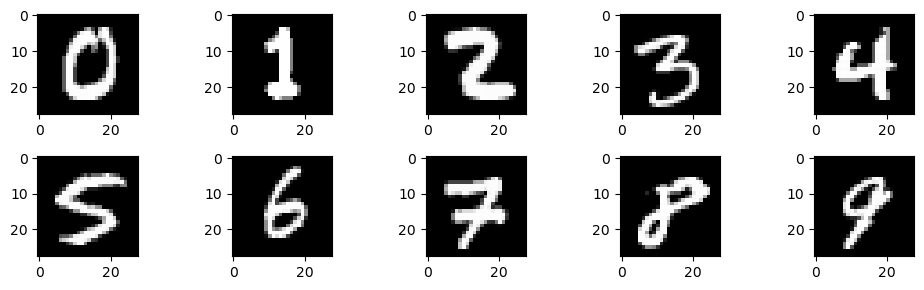

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))

for i, ax in enumerate(axes.flat):
    image = X_train_original[np.random.choice(np.where(y_train_original==i)[0])]
    fig = plt.figure
    ax.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

# Single-layer perceptron

### Creating Model - One Layer, Softmax Activation
### Steps

1. Creating a Model - Layer Weights and Biases
2. Define Forward propagation
3. Define Loss Function (mean)
4. Define Accuracy (mean)
5. Define Training (flatten, layers, biases, optimizer, train step)

In [32]:
def create_model(input_shape, output_shape, seed=42):
    """ Creating a One Layer Model
    Args: 
        input_shape: Input shape, => number of features
        output_shape: Output nodes / # of target class
        seed: Seed number for random.normal (reproducibility reason)
    Returns:
        layer_1 and bias_1 tf Variables
    """

    initializer = tf.initializers.RandomNormal(seed=seed)

    layer_1 = tf.Variable(initializer(shape=(input_shape, output_shape)), dtype=tf.float32, name="Weights_L1")
    bias_1 = tf.Variable(tf.zeros((output_shape,)), name="Biases_L1", dtype=tf.float32)

    return layer_1, bias_1

In [33]:
@tf.function
def forward_pass(input, weight, bias):
    """ Forward pass
    Args:
        input: Input features
        weight: Weights
        bias: Biases
    Returns:
        Softmax of (matmul+bias) layer output
    """
    return tf.nn.softmax(tf.matmul(input, weight) + bias)

In [34]:
@tf.function
def loss_fn(y_pred, y_true):
    """ Calculate Loss
    Args:
        y_pred: predictions
        y_true: true labels
    Returns:
        Mean loss    
    """

    return tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred))

In [35]:
@tf.function
def accuracy_fn(y_pred, y_true):
    """ Return Accuracy
    Args:
        y_red: Prediction
        y_true: True label
    Return: 
        Mean Accuracy
    """
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    

In [36]:
def train_model(X_train, y_train, X_val, y_val, learning_rate, batch_size, epochs):
    layer_1, layer_1_bias = create_model(X_train.shape[1], y_train.shape[1])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    @tf.function
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = forward_pass(inputs, layer_1, layer_1_bias)
            loss = loss_fn(targets, predictions)

        gradients = tape.gradient(loss, [layer_1, layer_1_bias])
        optimizer.apply_gradients(zip(gradients, [layer_1, layer_1_bias]))
        return loss

    best_test_accuracy = 0
    for epoch in range(epochs):
        for step in range(0, len(X_train), batch_size):
            x_batch = X_train[step:step+batch_size]
            y_batch = y_train[step:step+batch_size]
            loss = train_step(x_batch, y_batch)
        
        val_predictions = forward_pass(X_val, layer_1, layer_1_bias)
        val_accuracy = accuracy_fn(y_val, val_predictions)
        print(f"Epoch {epoch}, loss: {loss}, validation accuracy: {val_accuracy}")
        if val_accuracy > best_test_accuracy:
            best_test_accuracy = val_accuracy
    
    return best_test_accuracy

In [37]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epochs_list = [5, 50, 100, 200]

params = []
accuracy_list = []

X_train_org_flattened = X_train_original.reshape(-1, 784)
y_train_org_onehot = tf.keras.utils.to_categorical(y_train_original, num_classes=10)

for lr in learning_rates:
    for bs in batch_sizes:
        for epochs in epochs_list: ## Test Combinations on 5 fold
            accuracy_current_config = []

            for (train_index, test_index) in skf.split(X_train_original, y_train_original):

                X_train, y_train = X_train_org_flattened[train_index].astype("float32"), y_train_org_onehot[train_index]
                X_val, y_val = X_train_org_flattened[test_index].astype("float32"), y_train_org_onehot[test_index]

                val_accuracy = train_model(X_train, y_train, X_val, y_val, lr, bs, epochs)
                accuracy_current_config.append(val_accuracy)
            
            accuracy_list.append(accuracy_current_config)
            params.append([lr, bs, epochs])
            
            print(f"LR: {lr}, Batch Size: {bs}, Epochs: {epochs}, Val Accuracy: {np.mean(accuracy_current_config):.4f}")

In [16]:
print(f"Best 5 fold mean accuracy: {round(np.max(np.mean(np.array(accuracy_list), axis=1)), 4)}")

Best 5 fold mean accuracy: 0.9273999929428101


In [17]:
best_params = params[np.argmax(np.mean(np.array(accuracy_list), axis=1))]

In [12]:
best_params =  [0.0001, 16, 200]

In [70]:
X_train = X_train_original.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train_original.astype("float32")
y_test = y_test.astype("float32")

In [71]:
X_train_org_flattened = X_train.reshape(-1, 784)
y_train_org_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
X_test_org_flattened = X_test.reshape(-1, 784)
y_test_org_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)


In [72]:
final_layer_1, final_layer_1_bias = create_model(X_train_org_flattened.shape[1], y_train_org_onehot.shape[1])
final_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params[0])

In [73]:
@tf.function
def final_train_step(inputs, targets, final_optimizer):
    with tf.GradientTape() as tape:
        predictions = forward_pass(inputs, final_layer_1, final_layer_1_bias)
        loss = loss_fn(targets, predictions)
        
    gradients = tape.gradient(loss, [final_layer_1, final_layer_1_bias])
    final_optimizer.apply_gradients(zip(gradients, [final_layer_1, final_layer_1_bias]))
    return loss

In [75]:
for epoch in range(best_params[2]):
    for step in range(0, len(X_train), best_params[1]):
        x_batch = X_train_org_flattened[step:step+best_params[1]]
        y_batch = y_train_org_onehot[step:step+best_params[1]]
        loss = final_train_step(x_batch, y_batch, final_optimizer)
    print(f"Epoch: {epoch}, loss: {loss}")

test_predictions = forward_pass(X_test_org_flattened, final_layer_1, final_layer_1_bias)
test_accuracy = accuracy_fn(y_test_org_onehot, test_predictions)
print(f"Final test accuracy: {test_accuracy:.4f}")

Epoch: 0, loss: 3.3533668518066406
Epoch: 1, loss: 1.4760745763778687
Epoch: 2, loss: 0.8182022571563721
Epoch: 3, loss: 0.532853901386261
Epoch: 4, loss: 0.38504427671432495
Epoch: 5, loss: 0.29815271496772766
Epoch: 6, loss: 0.24212954938411713
Epoch: 7, loss: 0.20341667532920837
Epoch: 8, loss: 0.17518912255764008
Epoch: 9, loss: 0.1537063717842102
Epoch: 10, loss: 0.13678021728992462
Epoch: 11, loss: 0.12306220829486847
Epoch: 12, loss: 0.11168825626373291
Epoch: 13, loss: 0.10208647698163986
Epoch: 14, loss: 0.09386629611253738
Epoch: 15, loss: 0.08675452321767807
Epoch: 16, loss: 0.08055192977190018
Epoch: 17, loss: 0.07510720938444138
Epoch: 18, loss: 0.0703016147017479
Epoch: 19, loss: 0.06603871285915375
Epoch: 20, loss: 0.062239889055490494
Epoch: 21, loss: 0.058839235454797745
Epoch: 22, loss: 0.05578227713704109
Epoch: 23, loss: 0.053023092448711395
Epoch: 24, loss: 0.05052350461483002
Epoch: 25, loss: 0.04825114458799362
Epoch: 26, loss: 0.04617876186966896
Epoch: 27, loss

In [76]:
final_layer_1

<tf.Variable 'Weights_L1:0' shape=(784, 10) dtype=float32, numpy=
array([[ 0.00079085, -0.07950435,  0.00517972, ...,  0.01739371,
         0.0328981 ,  0.09575269],
       [ 0.01707336,  0.00210763,  0.06077656, ...,  0.02726117,
         0.05575596,  0.01813845],
       [ 0.11937493, -0.04969327, -0.02240689, ...,  0.00592999,
        -0.05882304, -0.08310866],
       ...,
       [ 0.01353821,  0.031753  , -0.00447592, ...,  0.01106444,
         0.0505494 ,  0.00893806],
       [-0.05666692, -0.04360975, -0.05564079, ...,  0.0342276 ,
        -0.12829943,  0.04709823],
       [-0.0237235 , -0.07918443, -0.0357438 , ..., -0.05982533,
        -0.0330737 , -0.00950607]], dtype=float32)>

In [77]:
final_layer_1_bias

<tf.Variable 'Biases_L1:0' shape=(10,) dtype=float32, numpy=
array([-1.0538634 ,  0.31892774,  0.21434893, -0.77978325,  0.60327023,
        2.2987156 , -0.0352282 ,  1.5394175 , -2.0949106 , -0.7434509 ],
      dtype=float32)>

In [82]:
y_pred = tf.argmax(test_predictions, axis=1).numpy()
y_true = tf.argmax(y_test_org_onehot, axis=1).numpy()

cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

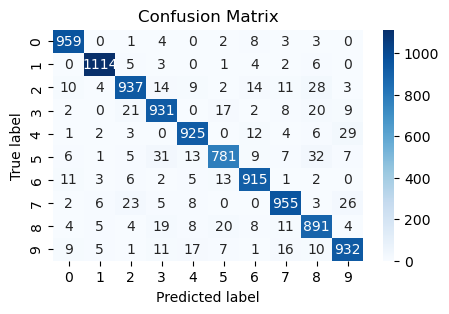

Validation Accuracy: 0.9340


In [83]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [85]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 10

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

Class 0:
  Precision: 0.9552
  Recall: 0.9786
  F1-score: 0.9667
Class 1:
  Precision: 0.9772
  Recall: 0.9815
  F1-score: 0.9793
Class 2:
  Precision: 0.9314
  Recall: 0.9079
  F1-score: 0.9195
Class 3:
  Precision: 0.9127
  Recall: 0.9218
  F1-score: 0.9172
Class 4:
  Precision: 0.9391
  Recall: 0.9420
  F1-score: 0.9405
Class 5:
  Precision: 0.9265
  Recall: 0.8756
  F1-score: 0.9003
Class 6:
  Precision: 0.9404
  Recall: 0.9551
  F1-score: 0.9477
Class 7:
  Precision: 0.9381
  Recall: 0.9290
  F1-score: 0.9335
Class 8:
  Precision: 0.8901
  Recall: 0.9148
  F1-score: 0.9023
Class 9:
  Precision: 0.9228
  Recall: 0.9237
  F1-score: 0.9232

Macro-average F1-score: 0.9330


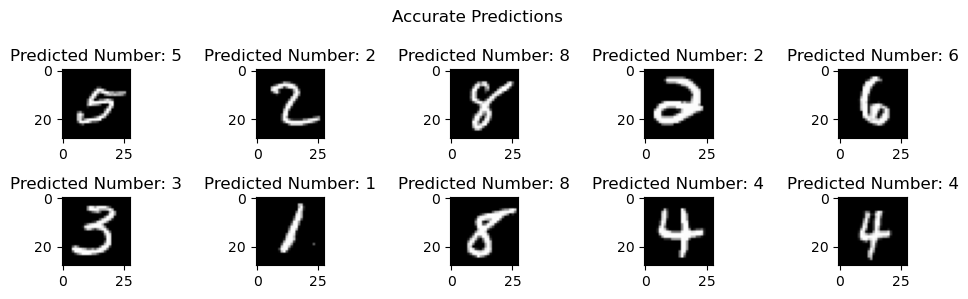

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))
plt.suptitle("Accurate Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(y_pred==y_true)[0])
    image = X_test[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Number: {y_pred[random_index]}")
    ax.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

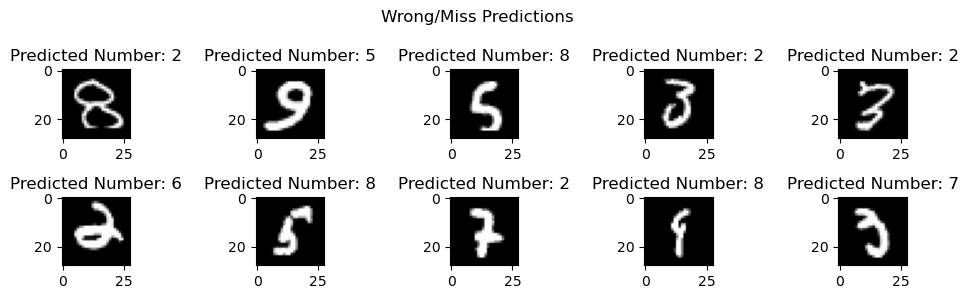

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))
plt.suptitle("Wrong/Miss Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(y_pred!=y_true)[0])
    image = X_test[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Number: {y_pred[random_index]}")
    ax.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

# Summary - Single Layer Perceptron

Accuracy is ~93% on 5 fold StratifiedKFold, and accomplished a ~93% accuracy on the test set

# Multilayer perceptron

### Creating Model - Two-Three Layer, Relu then Softmax Activation
### Steps

1. Creating a Model - Layer Weights and Biases
2. Define Forward propagation
3. Define Loss Function (mean)
4. Define Accuracy (mean)
5. Define Training (layers, biases, optimizer, train step)

In [45]:
# Load and Scale
(X_train_original, y_train_original), (X_test, y_test) = mnist.load_data()
(X_train_original, y_train_original), (X_test, y_test) = (X_train_original/255, y_train_original), (X_test/255, y_test)

In [46]:
def create_model(input_shape, output_shape, hidden_layer_nodes=tuple, seed=42):
    """ Define Model architecture
    Args:
        input_shape: input layer shape (number of nodes)
        output_shape: output layer shape (number of nodes) 
        hidden_layer_nodes: hidden layer shapes (number of hidden nodes in a list)
    Return:
        layers, biases    
    """

    layers = []
    biases = []

    initializer = tf.initializers.RandomNormal(seed=seed)

    l_input_w = tf.Variable(initializer(shape=(input_shape, hidden_layer_nodes[0])), dtype=tf.float32, name="Weights_input")
    l_input_b = tf.Variable(tf.zeros(shape=(hidden_layer_nodes[0], )), dtype=tf.float32, name="Biases_input")

    layers.append(l_input_w)
    biases.append(l_input_b)

    for i in range(len(hidden_layer_nodes)):
        if i != len(hidden_layer_nodes)-1:
            l_w = tf.Variable(initializer(shape=(hidden_layer_nodes[i], hidden_layer_nodes[i+1])), dtype=tf.float32, name=f"Weights_l{i+1}")
            l_b = tf.Variable(tf.zeros(shape=(hidden_layer_nodes[i+1],)), dtype=tf.float32, name=f"Biases_l{i+1}")     

            layers.append(l_w)
            biases.append(l_b)

        else:
            l_w = tf.Variable(initializer(shape=(hidden_layer_nodes[i], output_shape)), dtype=tf.float32, name="Weights_output")
            l_b = tf.Variable(tf.zeros(shape=(output_shape,)), dtype=tf.float32, name="Biases_output")
        
            layers.append(l_w)
            biases.append(l_b)
    

    return layers, biases


In [47]:
@tf.function
def forward_pass(input, layers, biases):

    for i in range(len(layers)):
        if i == 0:
            x = tf.nn.relu(tf.matmul(input, layers[i]) + biases[i])
        elif i == len(layers)-1:
            x = tf.matmul(x, layers[i]) + biases[i]
        else:
            x = tf.nn.relu(tf.matmul(x, layers[i]) + biases[i])

    return tf.nn.softmax(x)

In [48]:
@tf.function
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred))

In [49]:
def train_model(X_train, y_train, X_test, y_test, hidden_layer_nodes, learning_rate, batch_size, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    layers, biases = create_model(X_train.shape[1], y_train.shape[1], hidden_layer_nodes=hidden_layer_nodes)

    @tf.function
    def train_step(inputs, targets, layers, biases, optimizer):
        with tf.GradientTape() as tape:
            predictions = forward_pass(inputs, layers, biases)
            loss = loss_fn(targets, predictions)
        
        gradients = tape.gradient(loss, layers+biases)
        optimizer.apply_gradients(zip(gradients, layers+biases))
        
        return loss
    
    best_test_accuracy = 0
    for epoch in range(epochs):
        for step in range(0, len(X_train), batch_size):
            x_batch = X_train[step:step + batch_size]
            y_batch = y_train[step:step + batch_size]
            loss = train_step(x_batch, y_batch, layers, biases, optimizer)
        
        test_predictions = forward_pass(X_test, layers, biases)
        val_accuracy = accuracy_fn(y_test, test_predictions)
        if val_accuracy > best_test_accuracy:
            best_val_accuracy = val_accuracy
        print(f"Epoch {epoch}, loss: {loss}, validation accuracy: {val_accuracy}")

    return best_val_accuracy

In [50]:
def accuracy_fn(y_true, y_pred):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [37]:
skf = StratifiedKFold(n_splits=5)

In [ ]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 32]
epochs_list = [5, 100, 150]
hidden_layer_sizes = [(784, ), (784, 784), (784, 784, 784)]

params = []
accuracy_list = []

X_train_org_flattened = X_train_original.reshape(-1, 784).astype("float32")
y_train_org_onehot = tf.keras.utils.to_categorical(y_train_original, num_classes=10).astype("float32")

for lr in learning_rates:
    for bs in batch_sizes:
        for epochs in epochs_list:
            for hidden_sizes in hidden_layer_sizes:
                accuracy_current_config = []

                for (train_index, test_index) in skf.split(X_train_original, y_train_original):

                    X_train, y_train = X_train_org_flattened[train_index], y_train_org_onehot[train_index]
                    X_val, y_val = X_train_org_flattened[test_index], y_train_org_onehot[test_index]

                    val_accuracy = train_model(X_train, y_train, X_val, y_val, hidden_sizes, lr, bs, epochs)
                    accuracy_current_config.append(val_accuracy)

                accuracy_list.append(accuracy_current_config)
                params.append([lr, bs, epochs, hidden_sizes])
                
                print(f"LR: {lr}, Batch Size: {bs}, Epochs: {epochs}, Hidden Layers: {hidden_sizes}, Val Accuracy: {np.mean(accuracy_current_config):.4f}")


In [40]:
print(f"Best 5 fold mean accuracy: {round(np.max(np.mean(np.array(accuracy_list), axis=1)), 4)}")

Best 5 fold mean accuracy: 0.9804999828338623


In [41]:
best_params = params[np.argmax(np.mean(np.array(accuracy_list), axis=1))]

In [59]:
best_params = [0.0001, 16, 100, (784,)]

In [60]:
X_train = X_train_original.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train_original.astype("float32")
y_test = y_test.astype("float32")

In [61]:
X_train_org_flattened = X_train.reshape(-1, 784)
y_train_org_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
X_test_org_flattened = X_test.reshape(-1, 784)
y_test_org_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)


In [62]:
layers, biases = create_model(X_train_org_flattened.shape[1], y_train_org_onehot.shape[1], hidden_layer_nodes=best_params[-1])
final_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params[0])


In [63]:
@tf.function
def final_train_step(inputs, targets, layers, biases):
    
    with tf.GradientTape() as tape:
        predictions = forward_pass(inputs, layers, biases)
        loss = loss_fn(targets, predictions)
    
    gradients = tape.gradient(loss, layers+biases)
    final_optimizer.apply_gradients(zip(gradients, layers+biases))
    
    return loss

In [64]:
for epoch in range(best_params[2]):
    for step in range(0, len(X_train_org_flattened), best_params[1]):
        x_batch = X_train_org_flattened[step:step+best_params[1]]
        y_batch = y_train_org_onehot[step:step+best_params[1]]
        loss = final_train_step(x_batch, y_batch, layers, biases)
    print(f"Epoch: {epoch}, loss: {loss}")

test_predictions = forward_pass(X_test_org_flattened, layers, biases)
test_accuracy = accuracy_fn(y_test_org_onehot, test_predictions)
print(f"Final test accuracy: {test_accuracy:.4f}")

Epoch: 0, loss: 0.03784570470452309
Epoch: 1, loss: 0.01979724131524563
Epoch: 2, loss: 0.012556642293930054
Epoch: 3, loss: 0.008817357942461967
Epoch: 4, loss: 0.006937977857887745
Epoch: 5, loss: 0.005325326230376959
Epoch: 6, loss: 0.004316782578825951
Epoch: 7, loss: 0.003385895863175392
Epoch: 8, loss: 0.002769153332337737
Epoch: 9, loss: 0.002255102386698127
Epoch: 10, loss: 0.0017623178428038955
Epoch: 11, loss: 0.0013985520927235484
Epoch: 12, loss: 0.0010972551535815
Epoch: 13, loss: 0.0008810791186988354
Epoch: 14, loss: 0.0006167488754726946
Epoch: 15, loss: 0.00041229280759580433
Epoch: 16, loss: 0.0002947253524325788
Epoch: 17, loss: 0.00021426276362035424
Epoch: 18, loss: 0.00014680337335448712
Epoch: 19, loss: 0.00010437365563120693
Epoch: 20, loss: 6.800018309149891e-05
Epoch: 21, loss: 4.2257724999217317e-05
Epoch: 22, loss: 3.137023304589093e-05
Epoch: 23, loss: 1.9134247850161046e-05
Epoch: 24, loss: 1.0714386007748544e-05
Epoch: 25, loss: 6.675895747321192e-06
Epoc

In [65]:
y_pred = tf.argmax(test_predictions, axis=1).numpy()
y_true = tf.argmax(y_test_org_onehot, axis=1).numpy()

cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

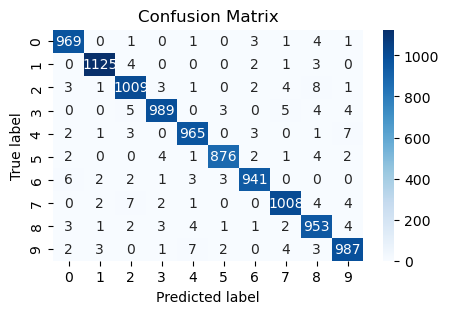

Validation Accuracy: 0.9822


In [66]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [67]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 10

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

Class 0:
  Precision: 0.9818
  Recall: 0.9888
  F1-score: 0.9853
Class 1:
  Precision: 0.9912
  Recall: 0.9912
  F1-score: 0.9912
Class 2:
  Precision: 0.9768
  Recall: 0.9777
  F1-score: 0.9772
Class 3:
  Precision: 0.9860
  Recall: 0.9792
  F1-score: 0.9826
Class 4:
  Precision: 0.9817
  Recall: 0.9827
  F1-score: 0.9822
Class 5:
  Precision: 0.9898
  Recall: 0.9821
  F1-score: 0.9859
Class 6:
  Precision: 0.9864
  Recall: 0.9823
  F1-score: 0.9843
Class 7:
  Precision: 0.9825
  Recall: 0.9805
  F1-score: 0.9815
Class 8:
  Precision: 0.9685
  Recall: 0.9784
  F1-score: 0.9734
Class 9:
  Precision: 0.9772
  Recall: 0.9782
  F1-score: 0.9777

Macro-average F1-score: 0.9821


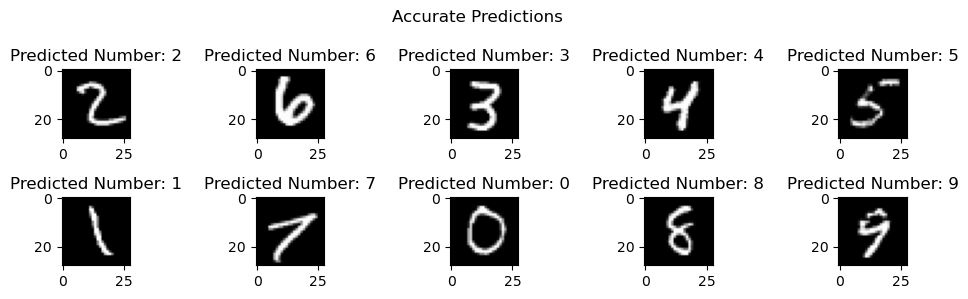

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))
plt.suptitle("Accurate Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(y_pred==y_true)[0])
    image = X_test[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Number: {y_pred[random_index]}")
    ax.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

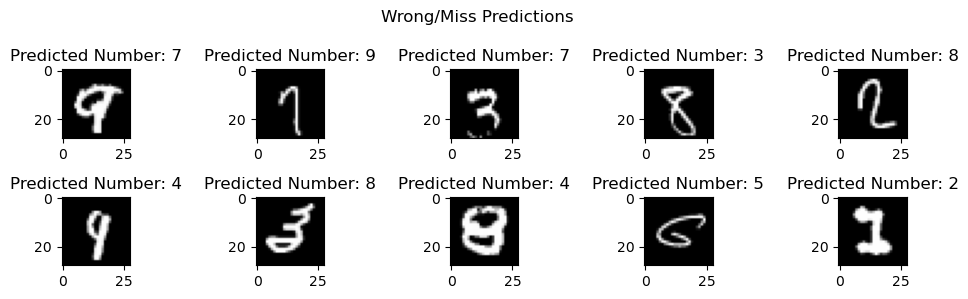

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))
plt.suptitle("Wrong/Miss Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(y_pred!=y_true)[0])
    image = X_test[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Number: {y_pred[random_index]}")
    ax.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

# Summary 

The accuracy is 98.2% on test set, Macro-average F1-score: 0.9821, "weaker" results at number 2 and 8!